In [1]:
%matplotlib inline
%load_ext Cython

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cython
sns.set()

In [2]:
%%cython
cimport cython
cimport numpy as np
import numpy as np

@cython.boundscheck(False)
@cython.wraparound(False)
def list_of_sequence_length_slippy(np.ndarray a):
    cdef int curi = 0
    cdef int i
    cdef int actu = -1
    out = []
    for i in range(len(a)):
        if actu != a[i] and a[i] != 0:
            if curi > 0:
                out.append(curi)
            curi = 0
            actu = a[i]
        if a[i] == actu:
            curi += 1
    if curi != 0:
        out.append(curi)
    return out

@cython.boundscheck(False)
@cython.wraparound(False)
def list_of_sequence_length(np.ndarray a):
    cdef int curi = 0
    cdef int i
    out = []
    for i in range(len(a)):
        if a[i] > 0:
            curi += 1
        else:
            if curi > 0:
                out.append(curi)
            curi = 0
    if curi != 0:
        out.append(curi)
    return out


def sequence_length(a):
    return list_of_sequence_length(a.values)

def sequence_length_slippy(a):
    return list_of_sequence_length_slippy(a.values)


def sequence_length_mean(a):
    elems = sequence_length(a)
    if elems:
        return np.mean(elems)
    else:
        return np.NaN

def sequence_length_slippy_mean(a):
    elems = sequence_length_slippy(a)
    if elems:
        return np.mean(elems)
    else:
        return np.NaN

In [100]:
plt.close('all')
num = 6999
run = 2
path = f"/data/logs/2018-06-20-1549-bm-rep-big-tp/other_noinv_fake/run_{run}/rep00"
path = f"/data/logs/2018-06-20-1541-bm-rep-big-fitprop/other_noinv_fake/run_{run}/rep00"


logpath = f"{path}/analysis_log_{num}.txt"
print(path)

/data/logs/2018-06-20-1541-bm-rep-big-fitprop/other_noinv_fake/run_2/rep00


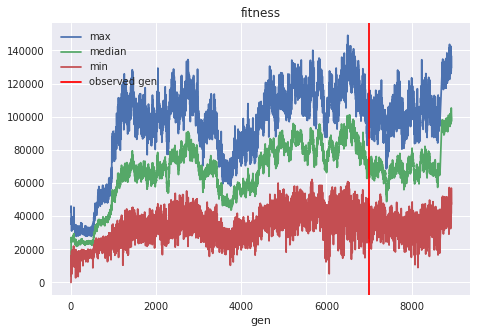

In [101]:
fail = False
fig, ax = plt.subplots(figsize=(5*1.5,5))

try:
    fitpath = f"{path}/fitnesslog.txt"
    fit = pd.read_csv(fitpath, delimiter="\t")
    maxrep = fit['rep'].max()
    fit = fit.query(f'rep == {maxrep}')
except pd.errors.EmptyDataError:
    fail = True
except pd.errors.ParserError:
    fail = True
else:
    fit.groupby('gen')['fitness'].max().plot(ax=ax, label='max')
    fit.groupby('gen')['fitness'].median().plot(ax=ax, label='median')
    fit.groupby('gen')['fitness'].min().plot(ax=ax, label='min')

if fail:
    fitpath = f"{path}/../fit.txt"
    pd.read_csv(fitpath, delimiter="\t") 
    fit.groupby('gen')['fitness'].max().plot(ax=ax, label='max')
    fit.groupby('gen')['fitness'].median().plot(ax=ax, label='median')
    fit.groupby('gen')['fitness'].min().plot(ax=ax, label='min')


ax.axvline(num, label="observed gen", color="red")
ax.legend()
ax.set_title('fitness')
plt.show(fig)

In [102]:
df = pd.read_csv(logpath, delimiter="\t")
df['TrueOnOpp'] = np.where(df['onOpp'] > 0, 1, 0)

In [103]:
timespent = df.groupby(['ind', 'coop', 'rep'])['onOpp'].apply(lambda x : pd.Series(sequence_length_slippy(x))).reset_index()
#timespent = df.groupby(['ind', 'coop', 'rep'])['onOpp'].apply(sequence_length_slippy_mean).reset_index()

In [104]:
timespent.max()

ind         99
coop        10
rep          2
level_3    771
onOpp      501
dtype: int64

Text(0.5,0,"coopération sur l'objet")

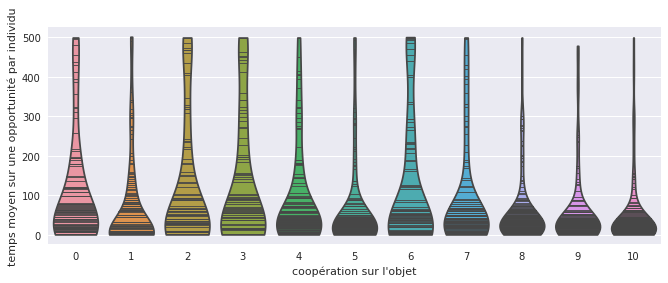

In [105]:
fig, ax = plt.subplots(figsize=(11, 4))
#sns.violinplot(data=timespent.groupby(['coop', 'ind'], as_index=False).mean(), x='coop', y='onOpp', cut=0, scale='count', inner='points')
sns.violinplot(data=timespent.query('ind == 24'), x='coop', y='onOpp', cut=0, inner='sticks', scale="width", ax=ax)
#ax = sns.stripplot(data=timespent.query('3.5 < coop < 6.5'), x='coop', y='onOpp', jitter=0.3, ax=ax)

plt.ylabel('temps moyen sur une opportunité par individu')
plt.xlabel('coopération sur l\'objet')

In [106]:
m = df.groupby(['ind', 'coop', 'rep'], as_index=False).mean();

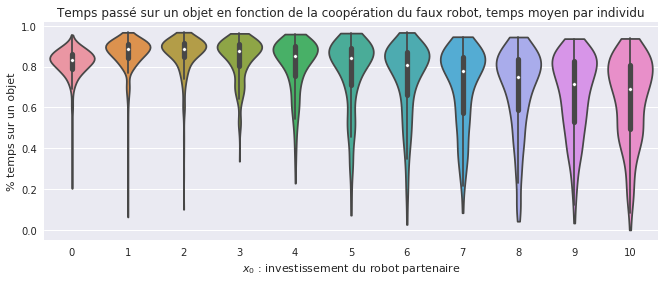

In [107]:
plt.figure(figsize=(11, 4))
sns.violinplot(data=m, x='coop', y='TrueOnOpp', cut=0, scale='count')
plt.title("Temps passé sur un objet en fonction de la coopération du faux robot, temps moyen par individu")
plt.ylabel("% temps sur un objet")
plt.xlabel("$x_0$ : investissement du robot partenaire");

In [108]:
df['totCoop'] = df['coop'] + df['ownCoop']

In [109]:
df['truecoop'] = np.where(df['onOpp'], df['ownCoop'], np.nan)
#df['truecoop'][np.where(np.isnan(df['truecoop']))[0] + 1] = np.nan

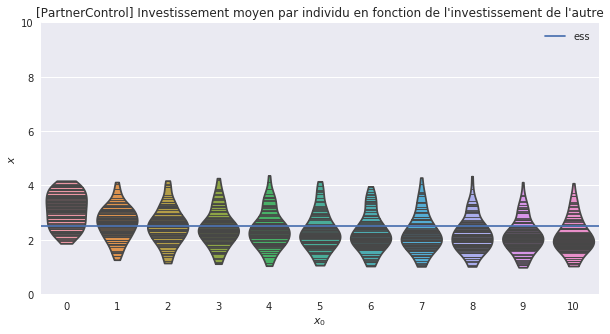

In [110]:
plt.figure(figsize=(10, 5))
sns.violinplot(data=df.query('onOpp > 0').groupby(['coop', 'ind'], as_index=False).mean(), cut=0, x='coop', y='ownCoop', scale='count', inner='stick')
plt.axhline(2.5, label='ess')
plt.title("[PartnerControl] Investissement moyen par individu en fonction de l'investissement de l'autre")
plt.legend()
plt.ylabel("$x$")
plt.xlabel("$x_0$")
plt.ylim(0, 10);

In [111]:
df['truecoop'] = np.where(df['onOpp'], df['ownCoop'], np.nan)

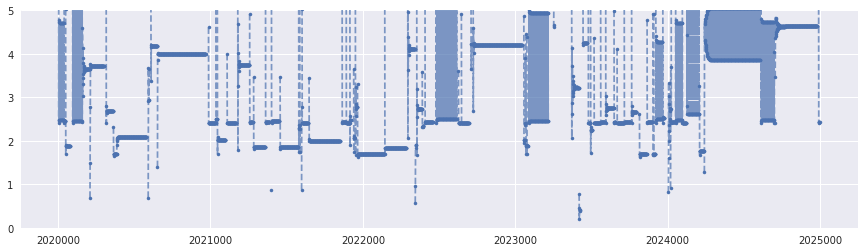

In [112]:
fig, ax = plt.subplots(figsize=(15, 4))
df.query('ind == 12 and coop == 2 and rep == 2')['truecoop'].plot(ax=ax, style='.')
df.query('ind == 12 and coop == 2 and rep == 2')['truecoop'].plot(ax=ax, style='--', alpha=0.7, c=sns.palettes.get_color_cycle()[0])
ax.set_ylim(0, 5)
plt.show()

------

In [12]:
best = df.groupby('ind', as_index=False).mean()['truecoop'].nlargest(20).index
worst = df.groupby('ind', as_index=False).mean()['truecoop'].nsmallest(20).index

In [13]:
m.loc[np.where(m['ind'].isin(best))[0], 'good'] = 'Cooperateur'
m.loc[np.where(m['ind'].isin(worst))[0], 'good'] = 'Egoiste'

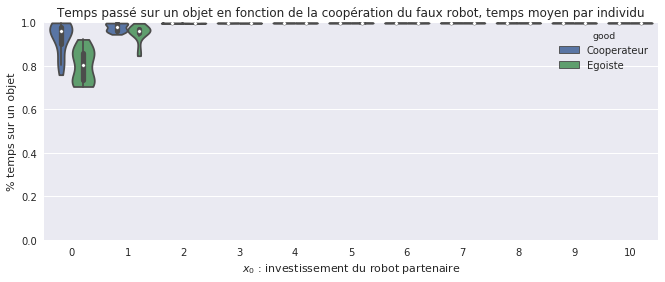

In [14]:
plt.figure(figsize=(11, 4))
sns.violinplot(data=m, x='coop', y='onOpp', cut=0, scale='count', hue='good')
plt.title("Temps passé sur un objet en fonction de la coopération du faux robot, temps moyen par individu")
plt.ylabel("% temps sur un objet")
plt.ylim(0, 1)
plt.xlabel("$x_0$ : investissement du robot partenaire");

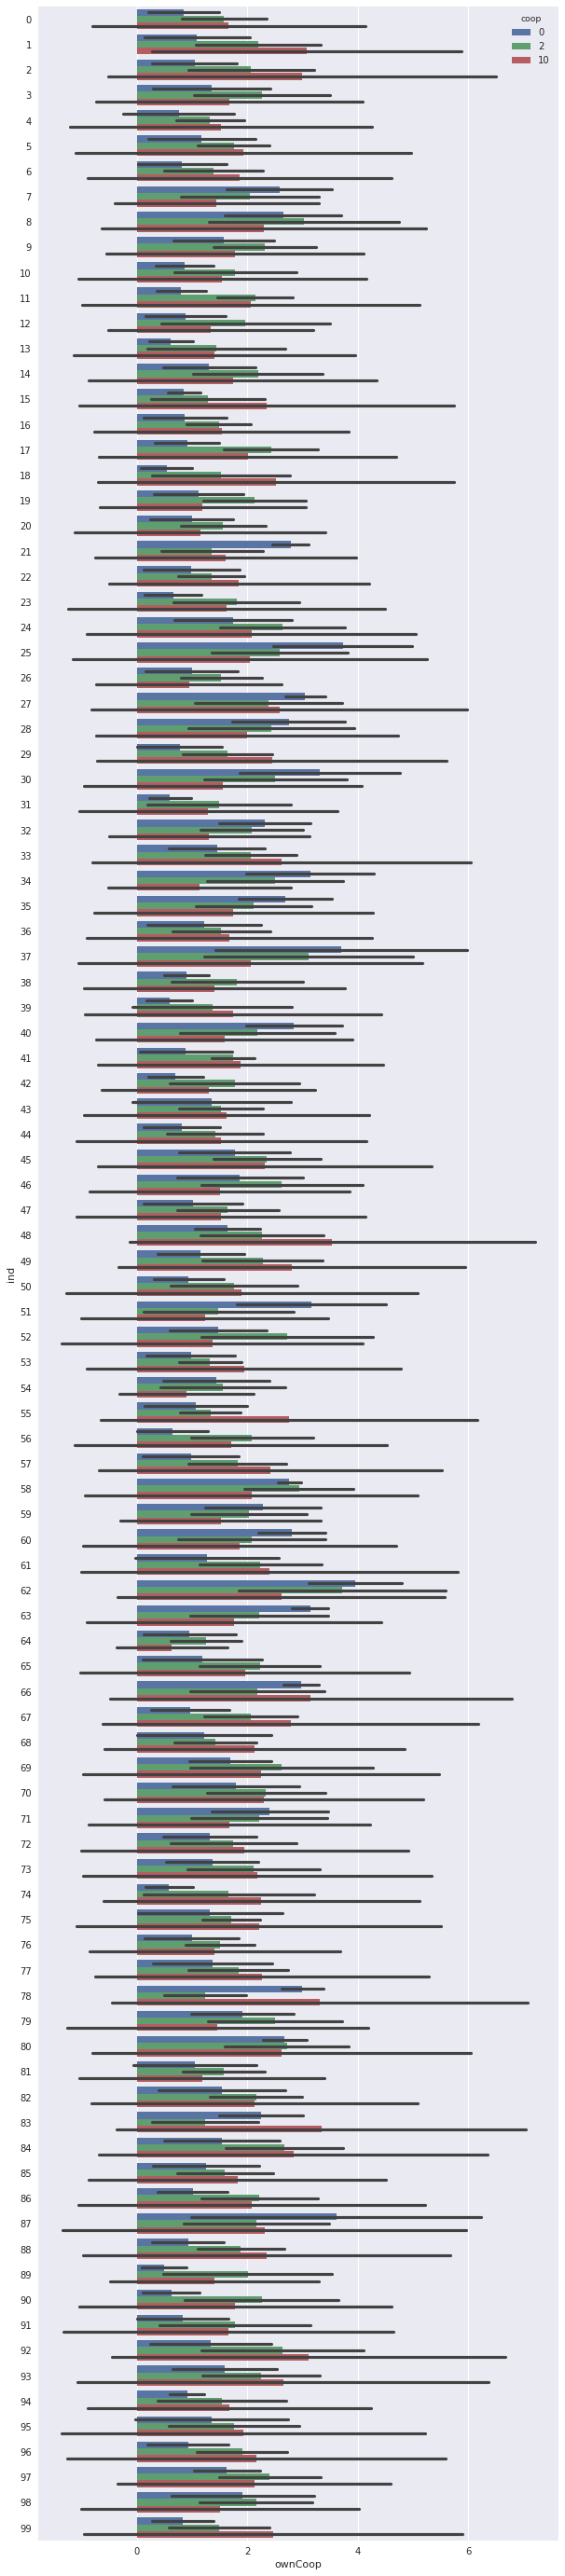

In [15]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 50))
sns.barplot(data=df.query('onOpp == 1 and ind < 100 and (coop==0 or coop==2 or coop==10)'), y='ind', x='ownCoop', orient='h', hue='coop',  ci='sd', ax=ax)